# Phase-Only Mult-Oscillator Model

In [1]:
# imports first! just the usual
import numpy as np
from scipy import integrate
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

## Background and Math

We are going to implement a model in which each neuron is simply tracking the angle of its clock hand. Without any signaling, each neuron has the following ODE

$$\frac{d\phi}{dt} = \omega$$

where $\phi$ is an angle in radians and $\omega$ is the intrinsic speed. A 24-h oscillator would have $\omega = \frac{2\pi}{24} = \frac{\pi}{12}$.

But, in the SCN, neurons are connected and receive signals that affect the speed of each clock. The most important of these is VIP. We have an idea of how VIP affects the phase of each neuron because Sungwon An (in the lab of Erik Herzog) collected a PRC to VIP (An et al, 2011). 


The PRC to VIP is show in Figure 1D:

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

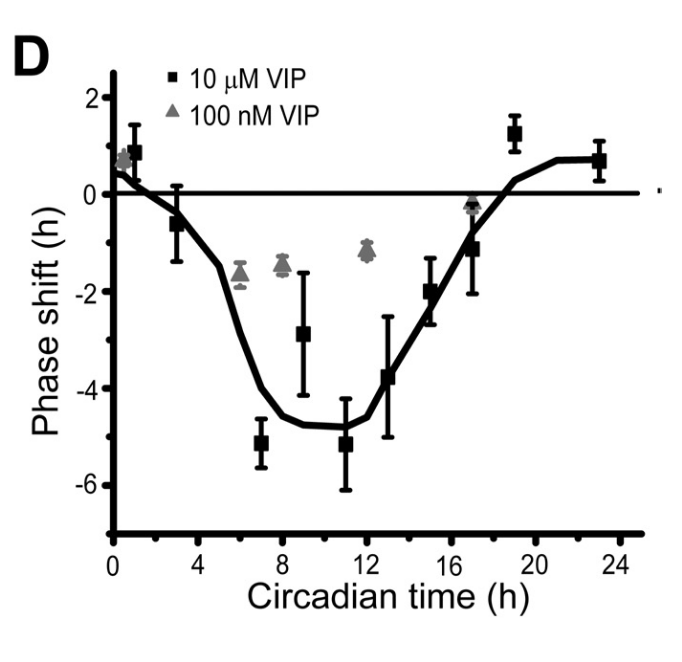
</div>

We see that the PRC is mostly delays and that the largest delay is at the end of the (CT12). I am going to make the assumption that this PRC (to an addition of VIP to the system) gives us the basic shape of the VRC. I am going to use a cosine curve for the sake of simplicity.

This makes the model more complicated. For the ith oscillator, we have

$$\frac{d\phi_i}{dt} = \omega + VRC(\phi_i(t)) \cdot VIPin_i(\vec{\phi(t)})$$

where $VIPin_i$ is the amount of VIP received by the ith oscillator. It is determined by the phases of the neurons that send VIP to neuron $i$ and by the amount of VIP being sent.

To determine $VIPin_i$ (a scalar), we need info about which neurons send how much VIP to neuron $i$. We will to represent the VIP coupling network with an adjacency matrix $A$. If there are $N$ neurons in the network, then the coupling network is $N \times N$. The entry $A_{i,j}$ gives us the fraction of VIP coming from neuron $j$ to neuron $i$ (so the columns indicate which neuron a signal is coming **from** and the rows indicate which neuron a signal is going **to**). We have a vector $\vec{VIPout}$ that contains the 1 in the jth location if VIP is being sent by neuron $j$ at that time. Then, we use matrix-vector multiplication to compute $\vec{VIPin}$.

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

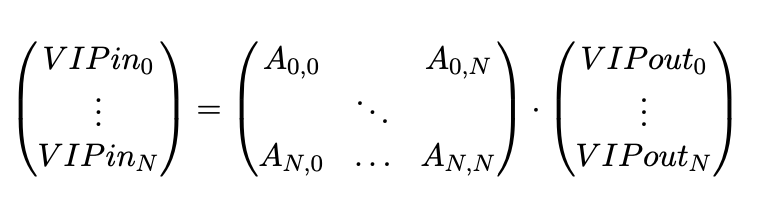
</div>

So, I write the entire model as

$$\frac{d\phi_i}{dt} = \omega + VRC(\phi_i(t)) \cdot VIPin_i(\vec{\phi(t)})$$

where

$$VIPin(\vec{\phi(t)}) = A \cdot VIPout(\vec{\phi(t)})$$

where $VIPout_j(\phi_j(t)) = 1$ if $\phi_j$ is in a given range and $0$ otherwise. Since VIP is day-active, it makes sense to have each cell output it during the day (that is CT0 to CT12, which is $\phi=0 to $\phi=\pi$.

*Reference*

An, S., Irwin, R. P., Allen, C. N., Tsai, C. A. & Herzog, E. D. Vasoactive intestinal polypeptide requires parallel changes in adenylate cyclase and phospholipase C to entrain circadian rhythms to a predictable phase. Journal of Neurophysiology 105, 2289–2296 (2011).

### VRC code

Let's start by generating a function that will produce a VIP PRC like that observed experimentally.

In [2]:
# This is function SRT grabbed from her jetlag paper.
# It is more adjustable than we need at the moment, but we will
# use it regardless.
# VRC that adjusts the area under a cosine curve.
# for VIP, shift_rad should be 0 rad
# for AVP, the ideal shift_rad is pi (half out of phase)
def VRC_adjustable3(phi,Darea,Aarea,shift_rad):
    phase = np.mod(phi+shift_rad,2*np.pi)
    if phase >= np.pi/2 and phase < np.pi/2+np.pi:
        # in the delay section
        a = Darea/0.5
    else:
        # in the advance section
        a = Aarea/0.5;
    VRC = a * np.cos( phase )
    return VRC

Plot the VRC that we will use by default. We will not have it be too delay-heavy. This is a simplifying assumption, and this is something that should be adjusted (explored this semester)

Text(0.5, 1.0, 'VRC')

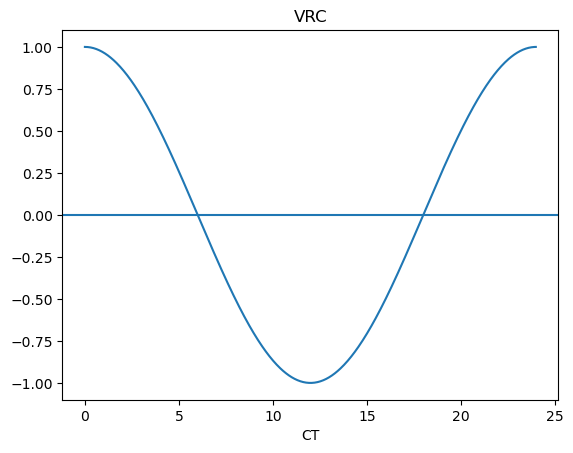

In [3]:
# Plot it!
VIP_Darea = 0.5
VIP_Aarea = 1-VIP_Darea
phis = np.arange( 0, 2*np.pi, 0.01 )
CTs = (12/np.pi)*phis
VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phis] ).reshape( (phis.size,) )
plt.plot( CTs, VIP_VRC )
plt.axhline()
plt.xlabel( "CT");
plt.title( "VRC")

*Activity*

Adjust the VIP_Darea, and plot the VRC to see how it controls it

Text(0.5, 1.0, 'VRC')

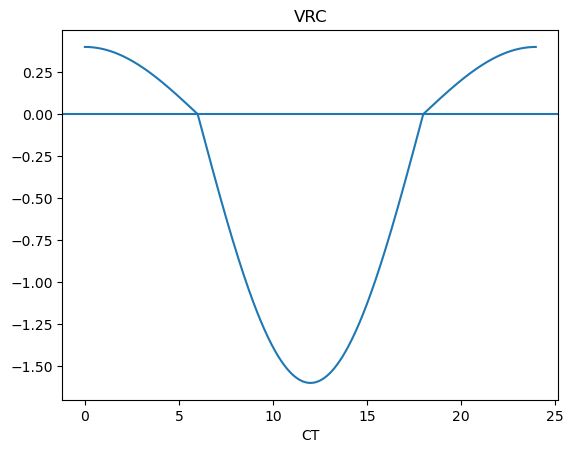

In [4]:
# your code here
VIP_Darea = 0.8
VIP_Aarea = 1-VIP_Darea
phis = np.arange( 0, 2*np.pi, 0.01 )
CTs = (12/np.pi)*phis
VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phis] ).reshape( (phis.size,) )
plt.plot( CTs, VIP_VRC )
plt.axhline()
plt.xlabel( "CT");
plt.title( "VRC")

### Adjacency matrix for VIP coupling network

The VIP coupling network is rather complicated, so let's write a function to create it. 

For a network to be connected, every cell must receive an input. In this case, a very few cells are supplying the output. Let's create the sparsest network possible - each neuron receives VIP from exactly one VIP cell. 

In our version 1 of the network, we will assume VIP cells don't receive VIP. There is biological evidence for this, but we will soon find this isn't the best assumption (hence, V2 of this function below).

In [5]:
# 10% of cells are VIP, and they are in the core. no reason not to put them next to each other because there is no local network among them.
# each non-VIP cell receives VIP from exactly one VIP cell
# In this model, the averaging is built into the matrix. In the mechanistic model, it isn't
# indexing: to, from
def VIP_conn_v1( N, VIP_strength ):
    if VIP_strength < 1e-8:
        return np.zeros( (N,N) )
    VIPcount = int( 0.1*N)
    half = N // 2
    A = np.zeros( (N,N) )
    for i in range(VIPcount):
        # every nonVIP cell gets in put from one VIP cell
        A[VIPcount+i::VIPcount,i] = VIP_strength
    denom = np.count_nonzero( A, axis=1 )
    for i in range(denom.size):
        if denom[i] > 0:
            A[i,:] = A[i,:] / denom[i]
    return A


### Code to plot a network

Check out the fancy curves.

In [6]:
def plot_network(conn, N, half, rows, cols, title=None):
    VIP_count = int(0.1*N)
    AVP_count = int(0.2*N)
    AVP_skip = 3 # 1/0.2/2 (20% of cells, but only shell cells and shell cells are 50% of cells. so it would be every 5th cell overall, but instead is every 2.5th so round to every 3rd
    plt.figure()
    for i in range(N):
        r1,c1 = np.unravel_index( i, (rows,cols))
        for j in range(N):
            if conn[i,j] > 0:
                r2,c2 = np.unravel_index( j, (rows,cols))
#                 plt.plot( (c1,c2), (r1,r2), 'k-' )
                if c1 > c2:
                    # arrow goes from c2 to c1, so it goes from right to left
                    cdiff = c1-c2-0.05
                elif c1 == c2:
                    cdiff = c1-c2
                else:
                    cdiff = c1-c2+0.05
                if r1 > r2:
                    # arrow goes from r2 to r1, so it goes up
                    rdiff = r1-r2-0.05
                elif r1 == r2:
                    rdiff = r1-r2
                else:
                    rdiff = r1-r2+0.05
#                 plt.arrow( c2, r2, cdiff, rdiff, color='k', alpha=0.5, head_width=0.1 )

                x1 = c2
                y1 = r2
                x2 = c2+cdiff
                y2 = r2+rdiff
                style = "Simple, tail_width=0.5, head_width=4, head_length=8"
                kw = dict(arrowstyle=style, color="k", alpha=0.5)
                arrow = patches.FancyArrowPatch((x1, -y1), (x2, y2),
                             connectionstyle="arc3,rad=.25", **kw)
                plt.gca().add_patch(arrow)                    
        if i < half:
            plt.plot( c1, r1, 'ro')
            # VIP cells are 10% of the cells and they are clustered in the core
            if i < VIP_count:
                plt.plot( c1, r1, 'yv' )
        else:
            plt.plot( c1, r1, 'bo')
            # AVP cells are 20% of the cells and they are spread out throughout the shell
            if np.mod(i-half, AVP_skip) == 0:
                plt.plot( c1, r1, 'm^' )
        if title is not None:
            plt.title(title)

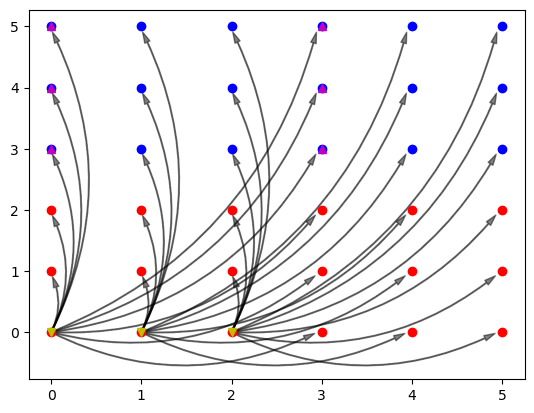

In [7]:
N = 36
VIP_strength = 1
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

VIPconn = VIP_conn_v1( N, VIP_strength )
plot_network( VIPconn, N, half, rows, cols )
plt.show()

*Activity*

Adjust the number of neurons to observe the network.

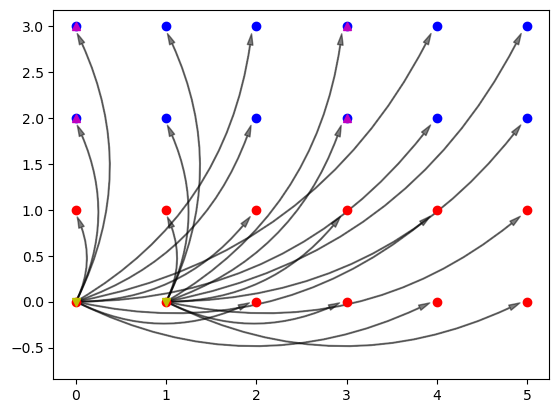

In [8]:
# code here
N = 24
VIP_strength = 1
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

VIPconn = VIP_conn_v1( N, VIP_strength )
plot_network( VIPconn, N, half, rows, cols )
plt.show()

*Question*

What is the color-coding for the neurons?

*Answer*:

### Make the model

First we have a class that will hold all the parameters

- an intrinsic speed for each oscillator
- Phases during which VIP is output
- balance of D and A areas under VIP VRC

Then, we write the model code and a function that will plot the output of the model

In [9]:
class Parameters_VipOnly:
    def __init__( self, N, intrinsic_periods = None, VIPconn = None, VIP_duration= np.pi/2 ):
        half = N // 2
        if intrinsic_periods is None:
            np.random.seed( 0 )
            intrinsic_periods = np.random.randn( N ) * 0.5
            intrinsic_periods[:half] += 25
            intrinsic_periods[half:] += 24.4
        VIP_active_start = np.pi/2-VIP_duration/2;
        VIP_active_stop = VIP_active_start+VIP_duration; 
        VIP_Darea = 0.5;
        # When setting up VIPconn, be sure to set it up to average the inputs (i.e.
        # divide each entry by the number of entries in the row
        # column index is "to"
        # row index is "from"
        if VIPconn is None:
            # use an all-to-all network
            VIPconn = 0.1 * np.ones( (N,N) )
            VIPconn = VIPconn / N
        self.N = N
        self.VIPconn = VIPconn
        self.intrinsic_speeds = np.reshape( (2*np.pi)/intrinsic_periods, (N,) )
        self.params = np.array( [VIP_Darea, VIP_active_start, VIP_active_stop] )

In [10]:
# Model function to be used by solve_ivp
# t is a scalar (time)
# phi is the vector of phases for each cell
# pobj is the Parameters_VipOnly object 
def model_vip_only(t,phi,pobj):
    N = pobj.N
    phi = np.mod(phi,2*np.pi);
    VIP_Darea = pobj.params[0] # fraction of total area
    VIP_Aarea = 1-VIP_Darea # fraction of total area
    VIP_active_start = pobj.params[1]
    VIP_active_stop = pobj.params[2]
    speed = pobj.intrinsic_speeds

    # Evaluate the VIP VRC at the phase for each of the oscillators
    VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phi] ).reshape( (N,) )
    VIP_output = np.zeros( (N,) )
    VIP_output[np.logical_and( VIP_active_start <= phi, phi <= VIP_active_stop )] = 1
    # This code makes it look like we sum the input, but the connectivity matrix is set up so that
    # each entry has already been divided by the number of entries that send to a particular cell
    VIP_input = pobj.VIPconn @ VIP_output

    dydt = speed + VIP_VRC*VIP_input
    return dydt


In [11]:
# Plot the output of the model
#  pobj is the Parameters_VipOnly object
#  sol is the output of solve_ivp
def plot_VIP_only( pobj, sol ):
    VIPsenders = pobj.VIPconn.sum(axis=0)
    phi = np.mod( sol.y, 2*np.pi )
    MP = np.sin( sol.y )
    plt.subplot( 3, 1, 1 )
    plt.plot( ts, phi.T )
    plt.plot( ts, phi[np.nonzero(VIPsenders)[0],:].T, 'y' )
    plt.ylabel( 'phi mod 2pi')
    plt.subplot( 3, 1, 2 )
    plt.plot( ts, MP.T, 'k', alpha=0.5 )
    plt.plot( ts, MP[np.nonzero(VIPsenders)[0],:].T, 'y' )
    plt.ylabel( 'Per mRNA')
    plt.subplot( 3, 1, 3 )
    dphidt = np.diff( sol.y.T, axis=0 )/(ts[1]-ts[0])
    plt.plot( ts[:-1], dphidt, 'k', alpha=0.2 );
    plt.plot( ts[:-1], np.diff( sol.y[np.nonzero(VIPsenders)[0],:].T, axis=0 )/(ts[1]-ts[0]), 'y', alpha=0.5 );    
    plt.xlabel( "time (h)")
    plt.plot( 'dphi/dt')
    plt.tight_layout()

### Simulate the model

took 0.671900749206543 seconds to simulate


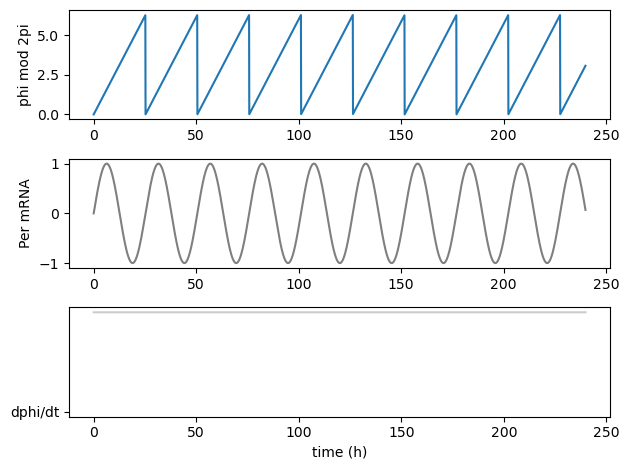

In [12]:
# Simulate 1 neuron without a network
N = 1
VIP_strength = 0
VIP_duration = 0
VIPconn = np.zeros( (N,N) )

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipOnly( N, VIPconn = VIPconn, VIP_duration=VIP_duration )
model = lambda t,ps: model_vip_only( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", t_eval = ts, max_step=0.01 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_only( pobj, sol )


*Question*: Explain the plots. What do you see?

*Answer*

took 4.155148029327393 seconds to simulate


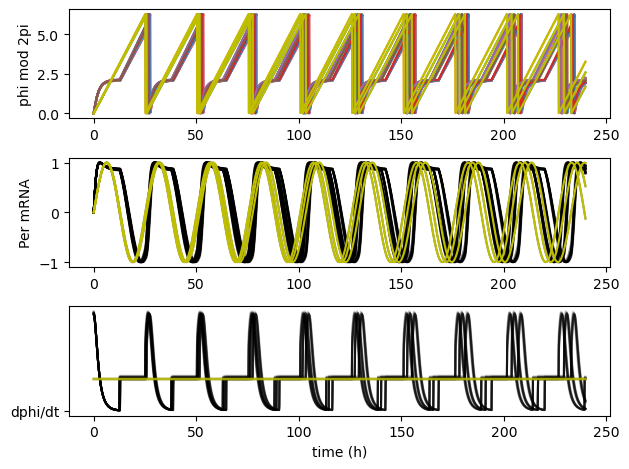

In [13]:
# Simulate and plot with VIP-only network (V1)
N = 36
VIP_strength = 0.5
VIP_duration = np.pi
VIPconn = VIP_conn_v1( N, VIP_strength )

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipOnly( N, VIPconn = VIPconn, VIP_duration=VIP_duration )
model = lambda t,ps: model_vip_only( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", t_eval = ts, max_step=0.01 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_only( pobj, sol )

*Question*: Explain the plots. What do you see?

*Answer*

### Make a more effective VIP adjacency matrix

In [14]:
# 10% of cells are VIP, and they are in the core. no reason not to put them next to each other because there is no local network among them.
# each cell receives VIP from exactly one VIP cell
# The key difference between this model and v1 is that VIP cells
# signal each other.
# In this model, the averaging is built into the matrix. In the mechanistic model, it isn't
# indexing: to, from
def VIP_conn_v2( N, VIP_strength ):
    if VIP_strength < 1e-8:
        return np.zeros( (N,N) )
    VIPcount = int( 0.1*N)
    half = N // 2
    A = np.zeros( (N,N) )
    for i in range(VIPcount):
        # to, from
        # every nonVIP cell gets input from one VIP cell
        A[VIPcount+i::VIPcount,i] = VIP_strength
        # Each VIP cell gets input from its neighbor in a 
        # circle
        A[(i+1)%VIPcount,i] = VIP_strength
    denom = np.count_nonzero( A, axis=1 )
    for i in range(denom.size):
        if denom[i] > 0:
            A[i,:] = A[i,:] / denom[i]
    return A



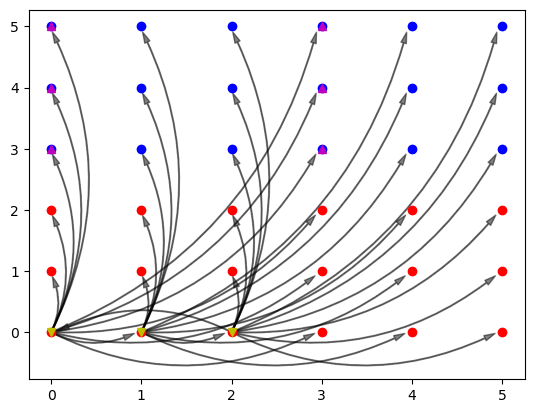

In [15]:
N = 36
VIP_strength = 1
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

VIPconn = VIP_conn_v2( N, VIP_strength )
plot_network( VIPconn, N, half, rows, cols )
plt.show()

took 3.9903759956359863 seconds to simulate


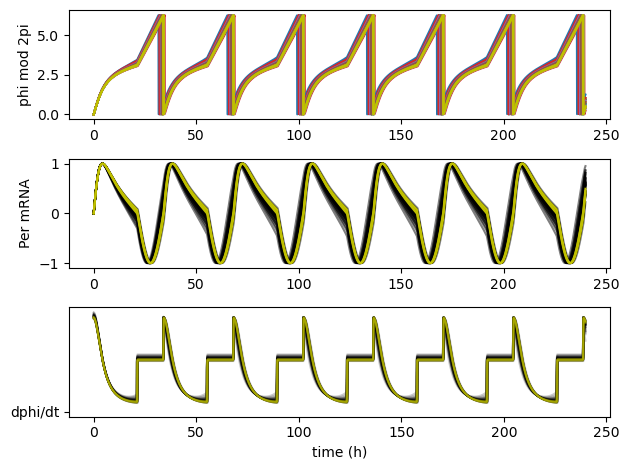

In [16]:
# Simulate with VIP-only network (V2)
N = 36
VIP_strength = 0.2 # Had to make this weaker because 0.5 stopped it
VIP_duration = np.pi
VIPconn = VIP_conn_v2( N, VIP_strength )

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipOnly( N, VIPconn = VIPconn, VIP_duration=VIP_duration )
model = lambda t,ps: model_vip_only( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", t_eval = ts, max_step=0.01 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_only( pobj, sol )

*Activity*

Adjust several parameters (one at a time), e.g. intrinsic speeds, duration of VIP output, Darea. Examine the effect on the synchrony.

In [17]:
# code here